In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import joblib 
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
import optuna
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from statsmodels.tsa.arima.model import ARIMA




In [12]:
data = pd.read_csv('housing_new.csv')
data = data.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'])
data = data[['new_date','flat_type', 'district', 'range_numeric' ,'floor_area_sqm', 'lease_commence_date', 'resale_price',]]

In [13]:
data.head()

,new_date,flat_type,district,range_numeric,floor_area_sqm,lease_commence_date,resale_price
0,1990.083333,1 ROOM,North-East,11.0,31.0,1977,9000.0
1,1990.083333,1 ROOM,North-East,5.0,31.0,1977,6000.0
2,1990.083333,1 ROOM,North-East,11.0,31.0,1977,8000.0
3,1990.083333,1 ROOM,North-East,8.0,31.0,1977,6000.0
4,1990.083333,3 ROOM,North-East,5.0,73.0,1976,47200.0


In [14]:
loaded_preprocessor = joblib.load('preprocessor.pkl')

In [15]:

transformed_data = loaded_preprocessor.transform(data)
# Extract feature names from the transformers
categorical_columns = ['district', 'flat_type']
numerical_columns = [ 'floor_area_sqm', 'range_numeric']

num_feature_names = numerical_columns
cat_feature_names = loaded_preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_columns)
remainder_feature_names = [col for col in data.columns if col not in numerical_columns + categorical_columns]

# Combine all feature names
all_feature_names = list(num_feature_names) + list(cat_feature_names) + remainder_feature_names

# Create a DataFrame with feature names
transformed_data = pd.DataFrame(transformed_data, columns=all_feature_names)


In [11]:
transformed_data.head()

,floor_area_sqm,range_numeric,district_East,district_North,district_North-East,district_West,flat_type_2 ROOM,flat_type_3 ROOM,flat_type_4 ROOM,flat_type_5 ROOM,new_date,lease_commence_date,resale_price
0,-2.758297,0.663203,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1990.083333,1977.0,9000.0
1,-2.758297,-0.563772,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1990.083333,1977.0,6000.0
2,-2.758297,0.663203,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1990.083333,1977.0,8000.0
3,-2.758297,0.049716,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1990.083333,1977.0,6000.0
4,-0.843622,-0.563772,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1990.083333,1976.0,47200.0


In [16]:
transformed_data.shape

(869645, 13)

In [38]:
X = transformed_data.drop('resale_price', axis=1)
y = transformed_data['resale_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [18]:

def objective(trial):
    param = {
        'learning_rate': trial.suggest_float('learning_rate', 0.07, 0.15),  # Focus around best trial, slightly wider
        'n_estimators': trial.suggest_int('n_estimators', 550, 650),         # Focus around best trial, wider range
        'max_depth': trial.suggest_int('max_depth', 10, 15),                   # Expanded depth range to include nearby values
        'subsample': trial.suggest_float('subsample', 0.9, 1.0),              # A tighter range around the best trial
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.9, 1.0), # Focus around the best trial
        'min_child_weight': trial.suggest_int('min_child_weight', 2, 7),      # Slightly expanded range from the best trial
        'reg_alpha': trial.suggest_float('reg_alpha', 0.07, 0.09),             # A wider range than the best trial
        'reg_lambda': trial.suggest_float('reg_lambda', 3, 4),            # A tighter range around the best trial
    }

    model = XGBRegressor(**param, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse

# Run the optimization with the updated parameter search space
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)  # Increased number of trials to explore more options

print("Best Trial:", study.best_trial.params)

[I 2025-01-06 12:44:59,348] A new study created in memory with name: no-name-0aa79b91-1c25-4c3a-8e1d-810a700192f8
[I 2025-01-06 12:45:30,053] Trial 0 finished with value: 798638635.2487508 and parameters: {'learning_rate': 0.094581353151067, 'n_estimators': 641, 'max_depth': 11, 'subsample': 0.9804890712725739, 'colsample_bytree': 0.9132306520804117, 'min_child_weight': 7, 'reg_alpha': 0.07943791198296175, 'reg_lambda': 3.4072909020895437}. Best is trial 0 with value: 798638635.2487508.
[I 2025-01-06 12:45:57,755] Trial 1 finished with value: 828422905.2907287 and parameters: {'learning_rate': 0.14677871445610244, 'n_estimators': 575, 'max_depth': 11, 'subsample': 0.900569442369212, 'colsample_bytree': 0.9248509597666931, 'min_child_weight': 6, 'reg_alpha': 0.08858932462367028, 'reg_lambda': 3.6571371851898826}. Best is trial 0 with value: 798638635.2487508.
[I 2025-01-06 12:46:21,346] Trial 2 finished with value: 802802071.588381 and parameters: {'learning_rate': 0.12874698602080953, 

Best Trial: {'learning_rate': 0.12240112256691944, 'n_estimators': 650, 'max_depth': 10, 'subsample': 0.9930674367239545, 'colsample_bytree': 0.9018188587583846, 'min_child_weight': 2, 'reg_alpha': 0.0847900282759657, 'reg_lambda': 3.9683566727090014}


In [39]:
# Random Forest Model with Optimized Parameters
rf_model = RandomForestRegressor(
    random_state=42,
    n_estimators=200,
    min_samples_split=6,
    min_samples_leaf =1        
        
)

# Gradient Boosting Model
xgb_model = XGBRegressor(
    learning_rate= 0.11280965749520883,
    n_estimators= 650, 
    random_state=42
)



In [40]:
# Training Models
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.11280965749520883,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=650, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

Random Forest MSE: 952392927.27, R²: 0.97
XGBoost MSE: 912694684.30, R²: 0.97
Ensemble MSE: 870622545.06, R²: 0.97


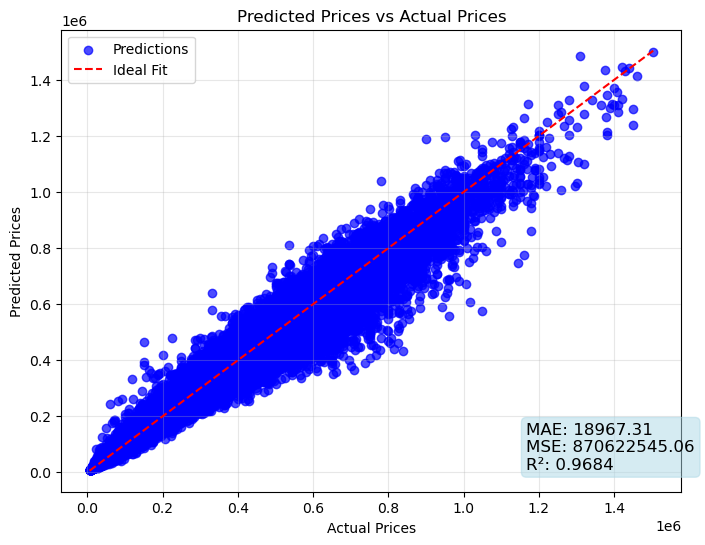

In [41]:
# Predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate Models
rf_mae = mean_absolute_error(y_test, y_pred_rf)
xgb_mae = mean_absolute_error(y_test, y_pred_xgb)
rf_mse = mean_squared_error(y_test, y_pred_rf)
xgb_mse = mean_squared_error(y_test, y_pred_xgb)
rf_r2 = r2_score(y_test, y_pred_rf)
xgb_r2 = r2_score(y_test, y_pred_xgb)

print(f"Random Forest MSE: {rf_mse:.2f}, R²: {rf_r2:.2f}")
print(f"XGBoost MSE: {xgb_mse:.2f}, R²: {xgb_r2:.2f}")

# Ensemble (Averaging Predictions)
ensemble_pred = (y_pred_rf + y_pred_xgb) / 2
ensemble_mae = mean_absolute_error(y_test,ensemble_pred)
ensemble_mse = mean_squared_error(y_test, ensemble_pred)
ensemble_r2 = r2_score(y_test, ensemble_pred)

print(f"Ensemble MSE: {ensemble_mse:.2f}, R²: {ensemble_r2:.2f}")

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, ensemble_pred, alpha=0.7, color='blue', label='Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Fit')


# Add labels, title, and legend
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Predicted Prices vs Actual Prices")
plt.legend()
plt.grid(alpha=0.3)

# Display the metrics on the plot
metrics_text = f"MAE: {ensemble_mae:.2f}\nMSE: {ensemble_mse:.2f}\nR²: {ensemble_r2:.4f}"
plt.gca().text(0.75, 0.15, metrics_text, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top',
               bbox=dict(boxstyle="round", alpha=0.5, color="lightblue"))
# Display the plot
plt.show()





In [ ]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

def plot_learning_curve(model, model_name, X, y, scoring='neg_mean_absolute_error'):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=5, scoring=scoring, 
        train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1)
    
    # Convert negative MAE to positive values (if applicable)
    train_scores_mean = -train_scores.mean(axis=1)
    val_scores_mean = -val_scores.mean(axis=1)
    
    # Plot the learning curve
    plt.plot(train_sizes, train_scores_mean, label=f'{model_name} - Training Error', marker='o')
    plt.plot(train_sizes, val_scores_mean, label=f'{model_name} - Validation Error', marker='o')
    plt.xlabel('Training Set Size')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.title(f'Learning Curve: {model_name}')
    plt.legend()
    plt.grid(True)

# Plot learning curves for Random Forest and XGBoost
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plot_learning_curve(rf_model, 'Random Forest', X_train, y_train)

plt.subplot(1, 2, 2)
plot_learning_curve(xgb_model, 'XGBoost', X_train, y_train)

plt.tight_layout()
plt.show()


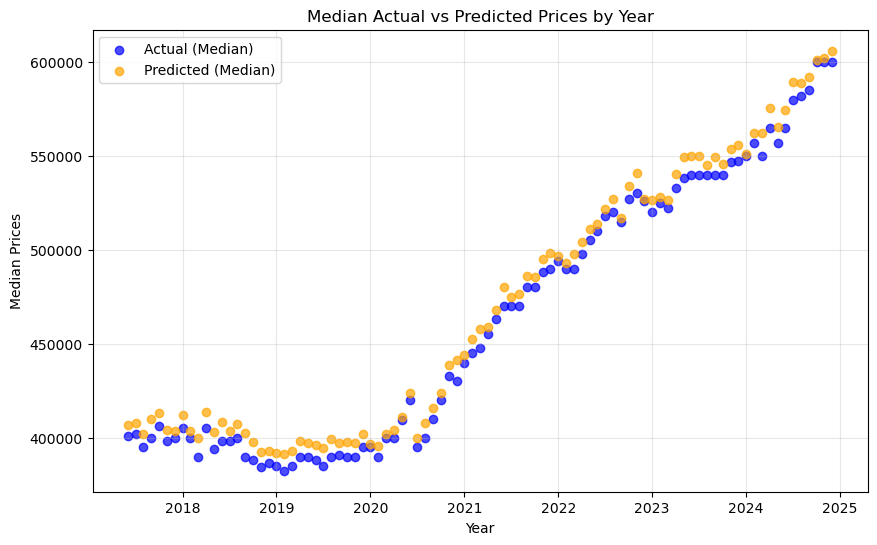

In [35]:

# Create a DataFrame to hold predictions and actual values
results_df = pd.DataFrame({
    'year': X_test['new_date'],
    'y_test': y_test,
    'ensemble_pred': ensemble_pred
})

# Group by year and calculate median
median_results = results_df.groupby('year').median().reset_index()

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(median_results['year'], median_results['y_test'], color='blue', label='Actual (Median)', alpha=0.7)
plt.scatter(median_results['year'], median_results['ensemble_pred'], color='orange', label='Predicted (Median)', alpha=0.7)

# Add labels, title, and legend
plt.xlabel("Year")
plt.ylabel("Median Prices")
plt.title("Median Actual vs Predicted Prices by Year")
plt.legend()
plt.grid(alpha=0.3)

# Show the plot
plt.show()

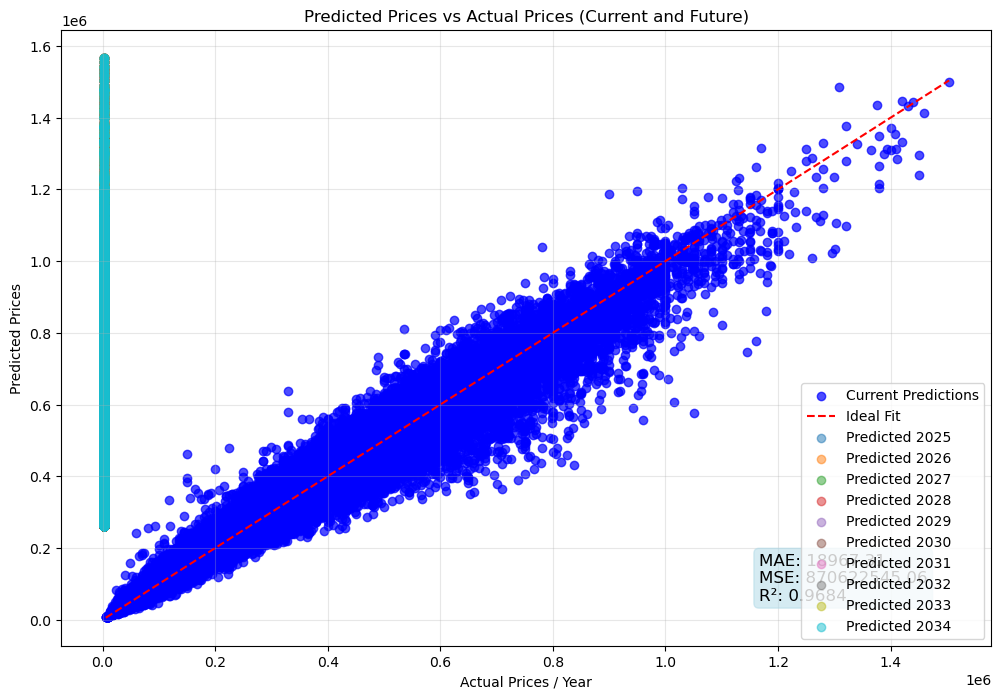

In [31]:

# Generate future dates (next 10 years)
future_years = np.arange(2025, 2035)
future_data = X_test.copy()

ensemble_future_prices = []

for year in future_years:
    future_data['new_date'] = year
    rf_future_prices = rf_model.predict(future_data)
    xgb_future_prices = xgb_model.predict(future_data)
    
    # Ensemble prediction for this year
    ensemble_year_pred = (rf_future_prices + xgb_future_prices) / 2
    ensemble_future_prices.append(ensemble_year_pred)

# Average predictions for each year
ensemble_future_prices = np.array(ensemble_future_prices)

# Plot actual vs predicted
plt.figure(figsize=(12, 8))
plt.scatter(y_test, ensemble_pred, alpha=0.7, color='blue', label='Current Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Fit')

# Plot future predictions
for idx, year in enumerate(future_years):
    plt.scatter([year] * len(ensemble_future_prices[idx]), ensemble_future_prices[idx], alpha=0.5, label=f'Predicted {year}')

# Add labels, title, and legend
plt.xlabel("Actual Prices / Year")
plt.ylabel("Predicted Prices")
plt.title("Predicted Prices vs Actual Prices (Current and Future)")
plt.legend()
plt.grid(alpha=0.3)

# Display metrics on the plot
metrics_text = f"MAE: {ensemble_mae:.2f}\nMSE: {ensemble_mse:.2f}\nR²: {ensemble_r2:.4f}"
plt.gca().text(0.75, 0.15, metrics_text, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top',
               bbox=dict(boxstyle="round", alpha=0.5, color="lightblue"))

# Show plot
plt.show()


In [ ]:
future_data = X_test.copy()
future_data['new_date'] = 2050  # Update date for future prediction
rf_future_prices = rf_model.predict(future_data) 
xgb_future_prices = xgb_model.predict(future_data)



In [23]:

lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

LinearRegression()

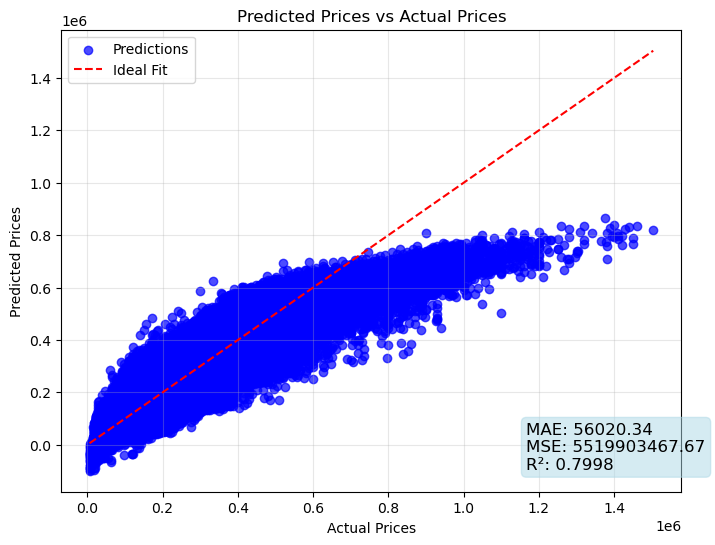

In [24]:
y_pred = lin_model.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue', label='Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Fit')


# Add labels, title, and legend
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Predicted Prices vs Actual Prices")
plt.legend()
plt.grid(alpha=0.3)

# Display the metrics on the plot
metrics_text = f"MAE: {mae:.2f}\nMSE: {mse:.2f}\nR²: {r2:.4f}"
plt.gca().text(0.75, 0.15, metrics_text, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top',
               bbox=dict(boxstyle="round", alpha=0.5, color="lightblue"))
# Display the plot
plt.show()

In [27]:
poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
poly_model.fit(X_train, y_train)


Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

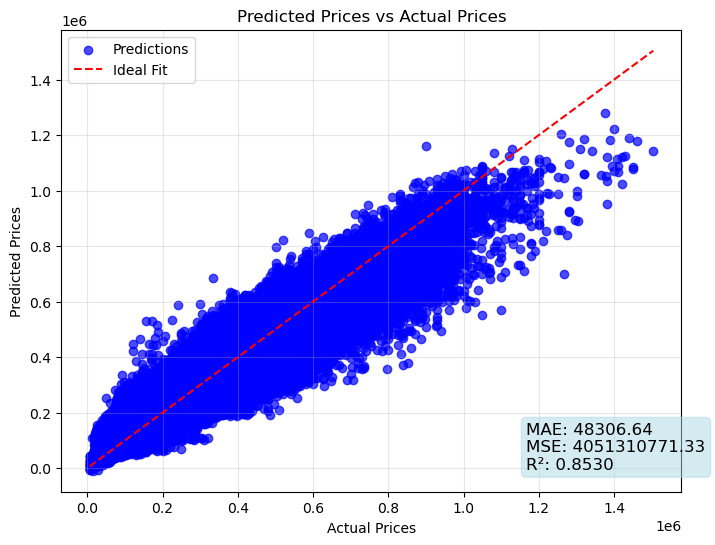

In [28]:
y_pred = poly_model.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue', label='Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Fit')


# Add labels, title, and legend
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Predicted Prices vs Actual Prices")
plt.legend()
plt.grid(alpha=0.3)

# Display the metrics on the plot
metrics_text = f"MAE: {mae:.2f}\nMSE: {mse:.2f}\nR²: {r2:.4f}"
plt.gca().text(0.75, 0.15, metrics_text, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top',
               bbox=dict(boxstyle="round", alpha=0.5, color="lightblue"))
# Display the plot
plt.show()

c:\Users\firas\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\firas\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\firas\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\firas\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\firas\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next versio

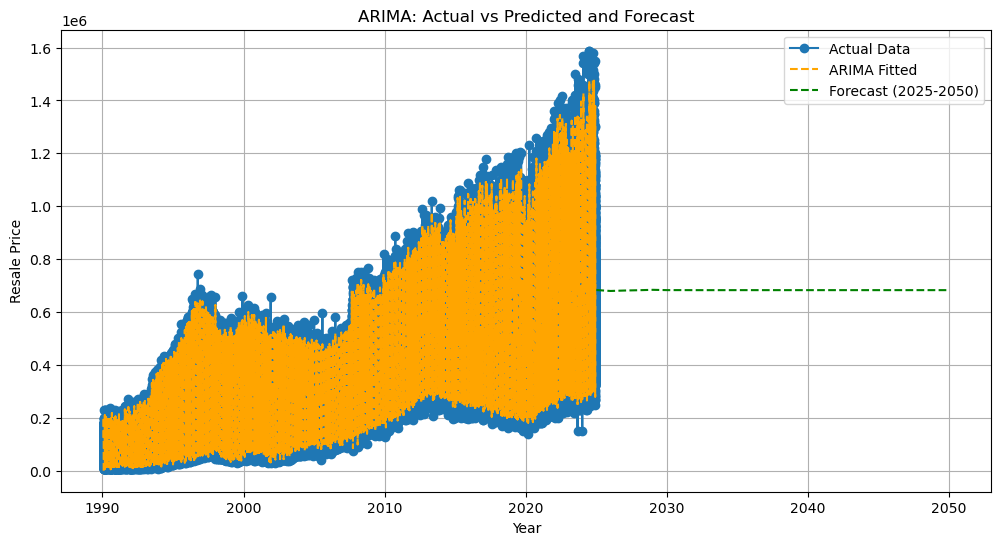

(3348885939.132387, 27700.24892551467, 0.8788192370629987)

In [30]:

# Assuming 'resale_price' is indexed by 'new_date'
time_series_data = data[['new_date', 'resale_price']].set_index('new_date')

# Fit ARIMA model
model = ARIMA(time_series_data, order=(5, 1, 0))
arima_fit = model.fit()

# Forecast future values (2024 to 2050)
future_forecast = arima_fit.forecast(steps=26)
forecast_years = np.arange(2025, 2051)

# Combine actual and forecast data for comparison
combined_data = pd.concat([time_series_data, pd.Series(future_forecast, index=forecast_years)])

# Metrics calculation (for training period)
train_actual = time_series_data.values
train_pred = arima_fit.fittedvalues

mse = mean_squared_error(train_actual, train_pred)
mae = mean_absolute_error(train_actual, train_pred)
r2 = r2_score(train_actual, train_pred)

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(time_series_data.index, time_series_data.values, label="Actual Data", marker='o')
plt.plot(time_series_data.index, train_pred, label="ARIMA Fitted", linestyle='--', color='orange')
plt.plot(forecast_years, future_forecast, label="Forecast (2025-2050)", linestyle='--', color='green')
plt.xlabel("Year")
plt.ylabel("Resale Price")
plt.title("ARIMA: Actual vs Predicted and Forecast")
plt.legend()
plt.grid(True)
plt.show()

mse, mae, r2
